In [1]:
# Basics
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Machine Learning/Stats
import scipy.stats as ss
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import ADASYN
from xgboost import XGBClassifier
import shap

# Others
import missingno as msno

In [2]:
pd.options.display.max_columns = 400

The dataset used on this project is available from Dua, D. and Graff, C. (2019). [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml). Irvine, CA: University of California, School of Information and Computer Science.

# Reading data and first glance at the data profile

In [3]:
df = pd.read_csv(r'data/campaigns.csv', index_col=0)

In [4]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


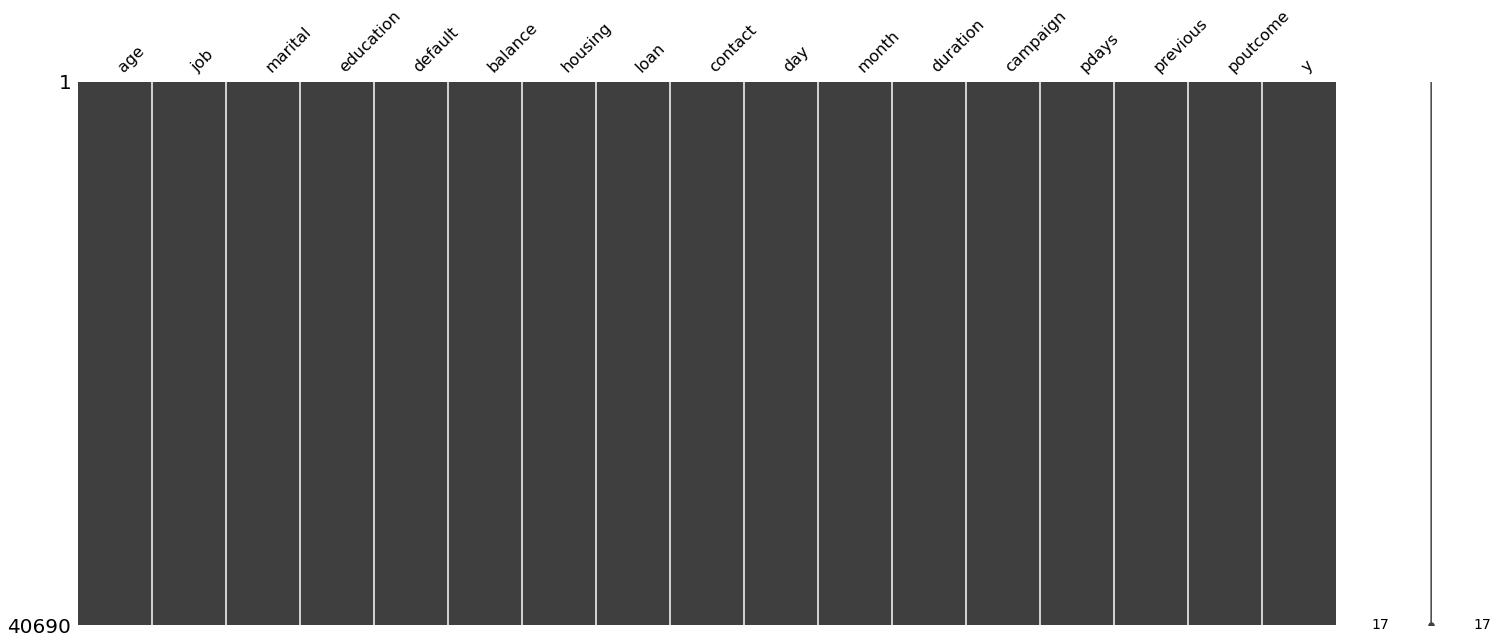

In [5]:
msno.matrix(df);

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40690 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40690 non-null  int64 
 1   job        40690 non-null  object
 2   marital    40690 non-null  object
 3   education  40690 non-null  object
 4   default    40690 non-null  object
 5   balance    40690 non-null  int64 
 6   housing    40690 non-null  object
 7   loan       40690 non-null  object
 8   contact    40690 non-null  object
 9   day        40690 non-null  int64 
 10  month      40690 non-null  object
 11  duration   40690 non-null  int64 
 12  campaign   40690 non-null  int64 
 13  pdays      40690 non-null  int64 
 14  previous   40690 non-null  int64 
 15  poutcome   40690 non-null  object
 16  y          40690 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.6+ MB


In [7]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,40690.000000,40690.000000,40690.000000,40690.000000,40690.000000,40690.000000,40690.000000
mean,40.905407,1359.697518,15.808405,258.243844,2.764586,40.059867,0.579405
std,10.604908,3034.248783,8.318281,257.577068,3.110158,100.078281,2.350664
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,74.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,451.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1423.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


## Target variable

In [8]:
df['y'].value_counts()

no     35903
yes     4787
Name: y, dtype: int64

**Note:** The first thing to keep in mind is that this will be an *imbalanced problem*, that will most likely require re-sampling methods

## Exploratory Data Analysis - Deep Dive

### Balance

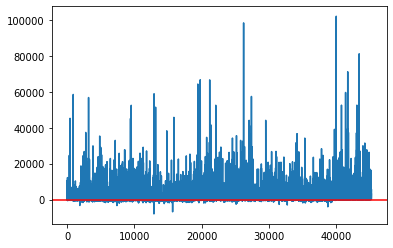

In [9]:
df['balance'].plot()
plt.axhline(color='r')

In [10]:
df['balance'].min()

-8019

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


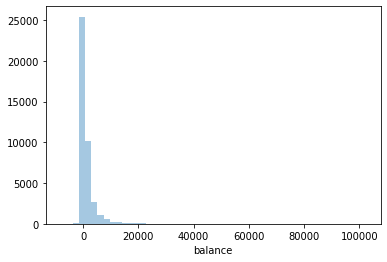

In [11]:
sns.distplot(df['balance'], kde=False)

**Note:** Does it make sense to have a negative balance? Are people in debt with that kind of situation? Should we then treat them as outliers or would we be losing information?

In [12]:
'People with negative balance represent ' + str(np.round(((df['balance']<0).astype(int).sum() / len(df) * 100),2)) + '%'

'People with negative balance represent 8.33%'

Since they represent more than 8% of the database, the decision from the Data Science team will be to leave them for now, perhaps being the ones in debt, but still needing to be validated with the business.

### Contact duration

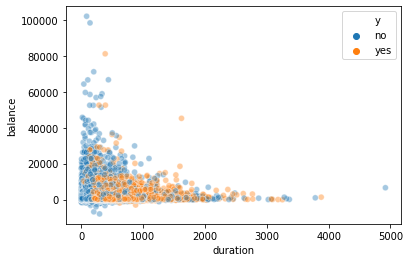

In [13]:
sns.scatterplot(data=df, x='duration', y='balance', hue='y', alpha=0.4)

**Note:** if the contact duration is longer, it has a higher chance that the customer will make a deal, regardless of their balance. So a possible action would be to prepare an *empathic* approach to make a conversation more interesting (in a customer centric fashion - i.e.: understand the reasons *why* the customer needs our product first)

### Number of contacts

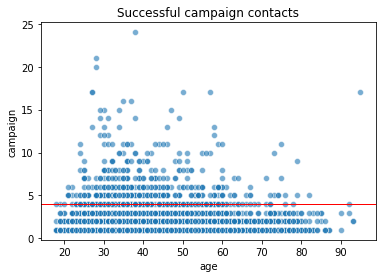

In [14]:
sns.scatterplot(data=df[df['y']=='yes'], x='age', y='campaign', alpha=0.6)
plt.axhline(y=df[df['y']=='yes']['campaign'].quantile(.9), color='r', linewidth=1)
plt.title("Successful campaign contacts");

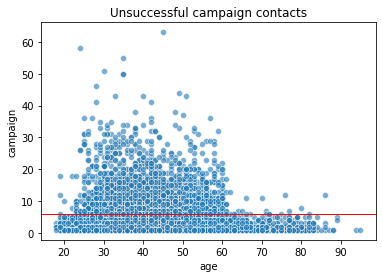

In [15]:
sns.scatterplot(data=df[df['y']=='no'], x='age', y='campaign', alpha=0.6)
plt.axhline(y=df[df['y']=='no']['campaign'].quantile(.9), color='r', linewidth=1)
plt.title("Unsuccessful campaign contacts");

**Note:** these plots indicate that for all ages, but **specially for younger ones** it is important to keep a smaller amount of contacts during each campaign. The red line drawn represent the 90% quantile for the data distribution.

In [16]:
df[df['pdays']>0]['y'].value_counts(1)

no     0.765619
yes    0.234381
Name: y, dtype: float64

In [17]:
df[df['pdays']<0]['y'].value_counts(1)

no     0.908351
yes    0.091649
Name: y, dtype: float64

**Note:** there is a trade-off to be analyzed between how many contacts to be made in order not to bore the client, but also make a contact in order to be remembered. It is less likely that a deal is made within the first contact

### Pairwise interactions plot

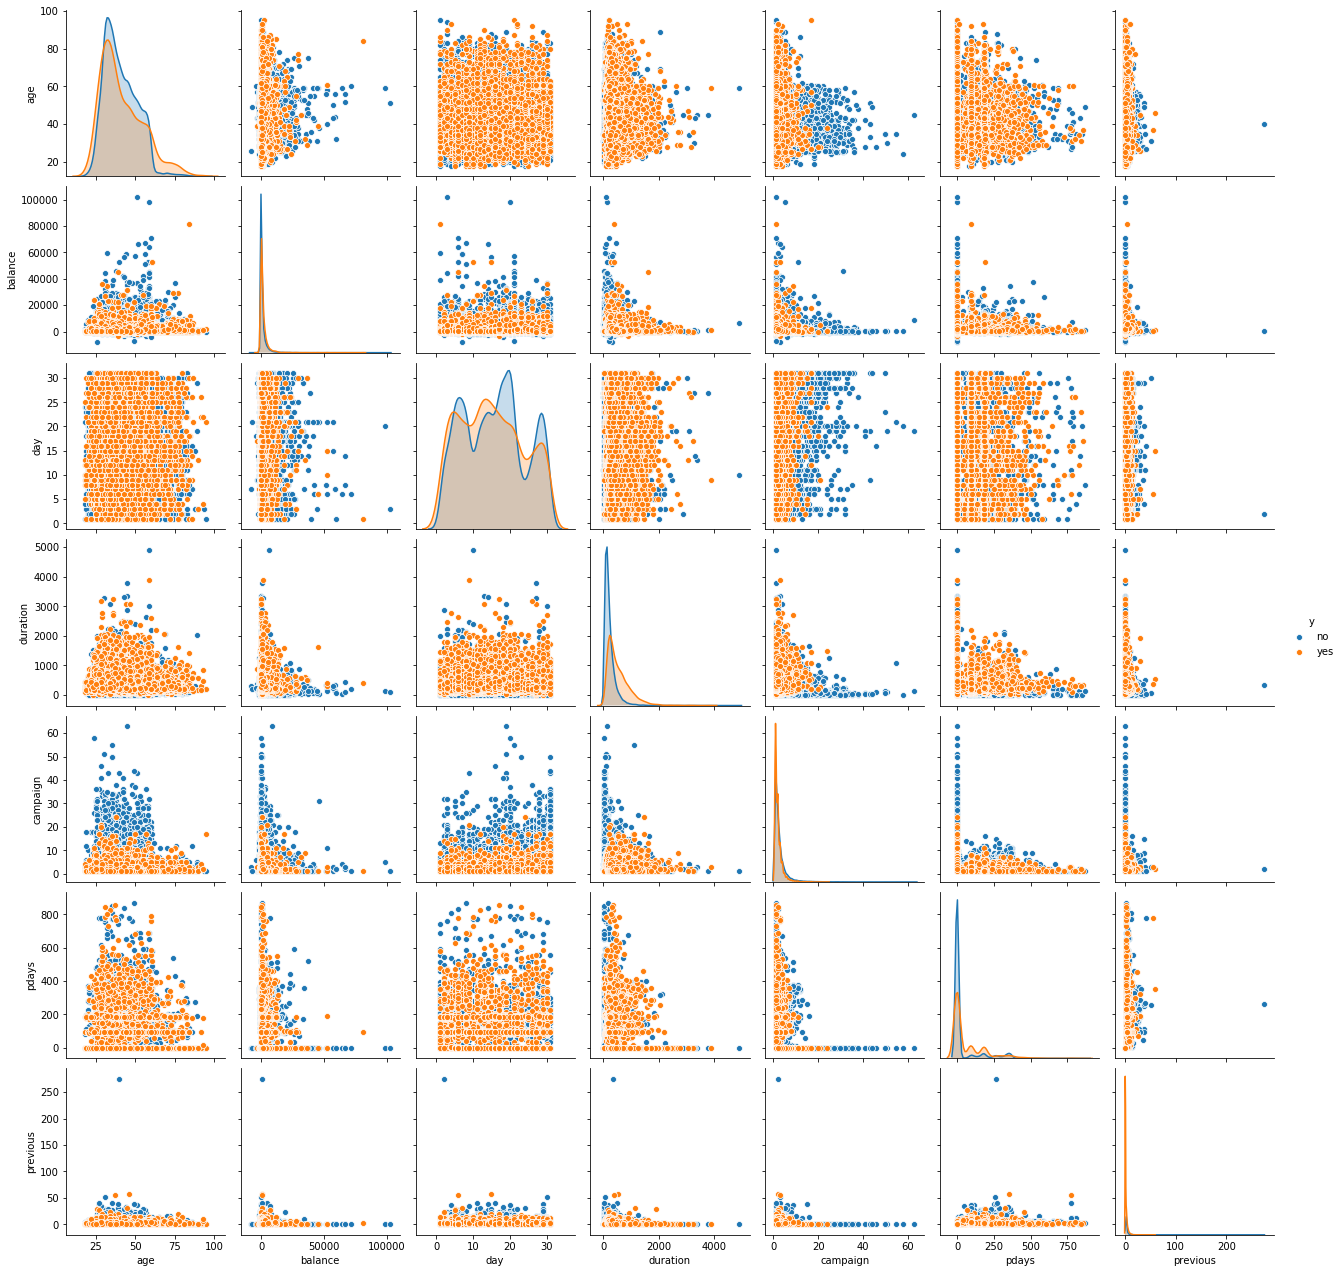

In [18]:
sns.pairplot(data=df, hue='y')

### Correlation matrix plot

Checking on the numerical correlations to see if anything shows up to be worth it to investigate

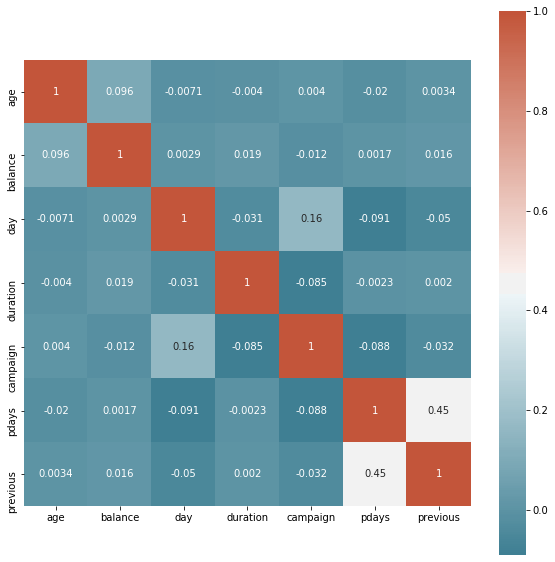

In [19]:
corr = df.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, square=True, cmap=sns.diverging_palette(220,20, n=300), annot=True)

**Note:** The only noticeable correlation shows up between pdays and previous. Although it might seem they are not strictly related, it still sustain the proposition of making a reasonable amount of contacts with the client, but not

## Categorical variables

In [20]:
cat_vars = []
for col in df.columns:
    if df[col].dtypes == np.object:
        cat_vars.append(col)

In [21]:
df[cat_vars].head(2)

,job,marital,education,default,housing,loan,contact,month,poutcome,y
0,management,married,tertiary,no,yes,no,unknown,may,unknown,no
1,technician,single,secondary,no,yes,no,unknown,may,unknown,no


In [22]:
df['job'].value_counts()

blue-collar      8769
management       8504
technician       6818
admin.           4661
services         3725
retired          2027
self-employed    1427
entrepreneur     1339
unemployed       1193
housemaid        1125
student           848
unknown           254
Name: job, dtype: int64

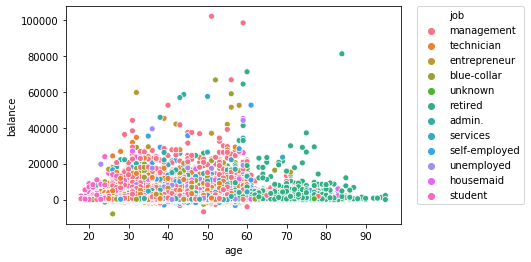

In [23]:
sns.scatterplot(data=df, x='age', y='balance', hue='job')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [24]:
df[df['y']=='yes'].groupby(by='job')['y'].size() / df.groupby(by='job')['y'].size()

job
admin.           0.124008
blue-collar      0.072642
entrepreneur     0.084391
housemaid        0.084444
management       0.138523
retired          0.230390
self-employed    0.120533
services         0.088859
student          0.291274
technician       0.110443
unemployed       0.155071
unknown          0.122047
Name: y, dtype: float64

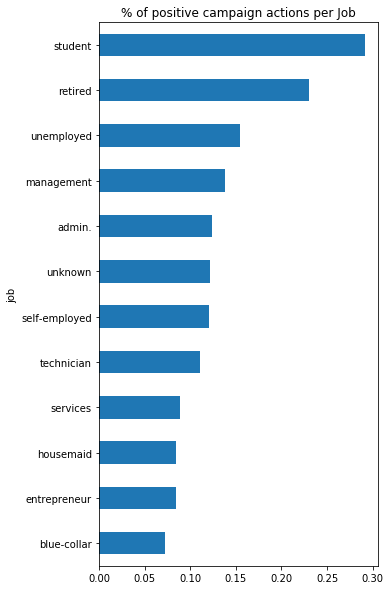

In [25]:
plt.figure(figsize=(5,10))
plt.title('% of positive campaign actions per Job')
(df[df['y']=='yes'].groupby(by='job').size() / df.groupby(by='job').size()).sort_values(ascending=True).plot.barh();

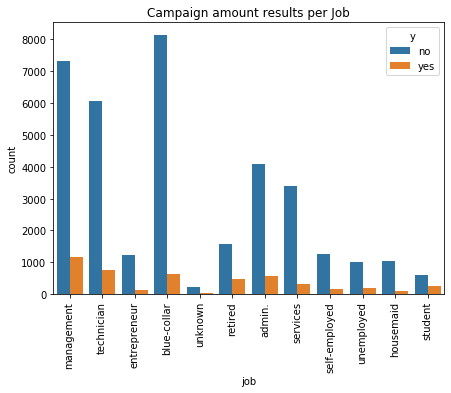

In [26]:
plt.figure(figsize=(7,5))
plt.title('Campaign amount results per Job')
sns.countplot(data=df, x='job', hue='y')
plt.xticks(rotation=90);

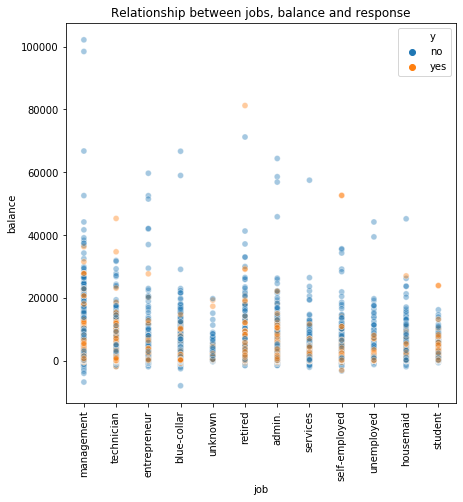

In [27]:
plt.figure(figsize=(7, 7))
plt.title('Relationship between jobs, balance and response')
sns.scatterplot(x='job', y='balance', data=df, hue='y', alpha=0.4)
plt.xticks(rotation=90);

**Note:** proportionally, the campaign seems to be working best amongst students, retired and unemployed people. the best segment of "regular" jobs are the management ones, and blue collar performs the worst, along with entrepreneurs, housemaids and services.

### Marital Status

In [28]:
df['marital'].value_counts()

married     24464
single      11531
divorced     4695
Name: marital, dtype: int64

In [29]:
df[df['y']=='yes']['marital'].value_counts(1)

married     0.518488
single      0.362231
divorced    0.119281
Name: marital, dtype: float64

**note:** it seems that married people are the most prone to react to our mkt campaing, but it is worth it to investigate it proportionally among each category

In [30]:
df[df['marital']=='married']['y'].value_counts(1)

no     0.898545
yes    0.101455
Name: y, dtype: float64

In [31]:
df[df['marital']=='single']['y'].value_counts(1)

no     0.849623
yes    0.150377
Name: y, dtype: float64

In [32]:
df[df['marital']=='divorced']['y'].value_counts(1)

no     0.878381
yes    0.121619
Name: y, dtype: float64

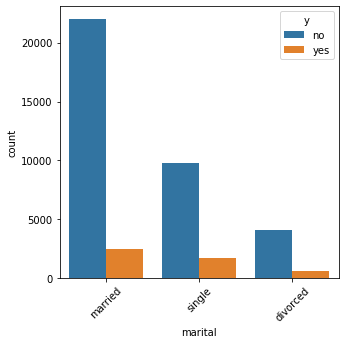

In [33]:
plt.figure(figsize=(5,5))
sns.countplot(data=df, x='marital', hue='y')
plt.xticks(rotation=45);

**note:** On the other hand the plot and the numbers really show that married people are in fact (not by much) the **worst** investment in the campaign

### Education

In [34]:
df['education'].value_counts()

secondary    20951
tertiary     11917
primary       6153
unknown       1669
Name: education, dtype: int64

In [35]:
df[df['y']=='yes']['education'].value_counts(1)

secondary    0.466681
tertiary     0.374765
primary      0.110090
unknown      0.048465
Name: education, dtype: float64

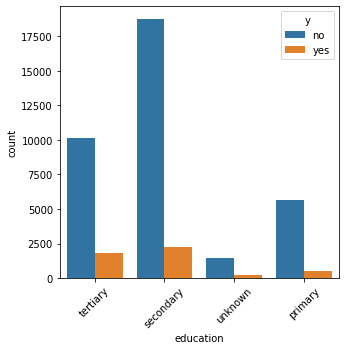

In [36]:
plt.figure(figsize=(5,5))
sns.countplot(data=df, x='education', hue='y')
plt.xticks(rotation=45);

**note:** although the highest number of positive actions was placed on the 'secondary' category, it seems that the higher education tends to influence on how positive the campaign is going to be.

### Market pendencies

In [37]:
df['default'].value_counts(1)

no     0.982182
yes    0.017818
Name: default, dtype: float64

In [38]:
df[df['y']=='yes']['default'].value_counts(1)

no     0.990182
yes    0.009818
Name: default, dtype: float64

In [39]:
df[df['y']=='no']['default'].value_counts(1)

no     0.981116
yes    0.018884
Name: default, dtype: float64

**note:** there is a slight increase in how less often the customer has credit default if they react positively to the campaign

In [40]:
df['housing'].value_counts(1)

yes    0.556918
no     0.443082
Name: housing, dtype: float64

In [41]:
df[df['y']=='yes']['housing'].value_counts(1)

no     0.635262
yes    0.364738
Name: housing, dtype: float64

In [42]:
df[df['y']=='no']['housing'].value_counts(1)

yes    0.582542
no     0.417458
Name: housing, dtype: float64

**note:** there is a higher probability the customer will subscribe in case they don't have a housing loan

In [43]:
df[df['y']=='yes']['loan'].value_counts(1)

no     0.907458
yes    0.092542
Name: loan, dtype: float64

In [44]:
df[df['y']=='no']['loan'].value_counts(1)

no     0.830933
yes    0.169067
Name: loan, dtype: float64

**note:** the same as the previous two will happen for the personal loan

### Contact information

In [45]:
df['contact'].value_counts()

cellular     26319
unknown      11771
telephone     2600
Name: contact, dtype: int64

In [46]:
df[df['y']=='yes']['contact'].value_counts(1)

cellular     0.826405
unknown      0.098809
telephone    0.074786
Name: contact, dtype: float64

In [47]:
df[df['y']=='no']['contact'].value_counts(1)

cellular     0.622873
unknown      0.314681
telephone    0.062446
Name: contact, dtype: float64

**note:** the more is known about the communication channel, higher the chance the campaign will be successful

In [48]:
df['poutcome'].value_counts(1)

unknown    0.817990
failure    0.107569
other      0.040501
success    0.033940
Name: poutcome, dtype: float64

In [49]:
df[df['y']=='yes']['poutcome'].value_counts(1)

unknown    0.637560
success    0.186756
failure    0.116566
other      0.059118
Name: poutcome, dtype: float64

### Correlation - Cramer's V

To identify the categorical variables association, we will use the Cramer's V modified calculation, inspired by [this article](https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9)

In [50]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [51]:
corr_cat = np.zeros(shape=(len(cat_vars),len(cat_vars)))
for i,vari in enumerate(cat_vars):
    for j,varj in enumerate(cat_vars):
        corr_cat[i][j]=(cramers_v(df[vari],df[varj]))
corr_cat_df = pd.DataFrame(corr_cat, columns=cat_vars, index=cat_vars)

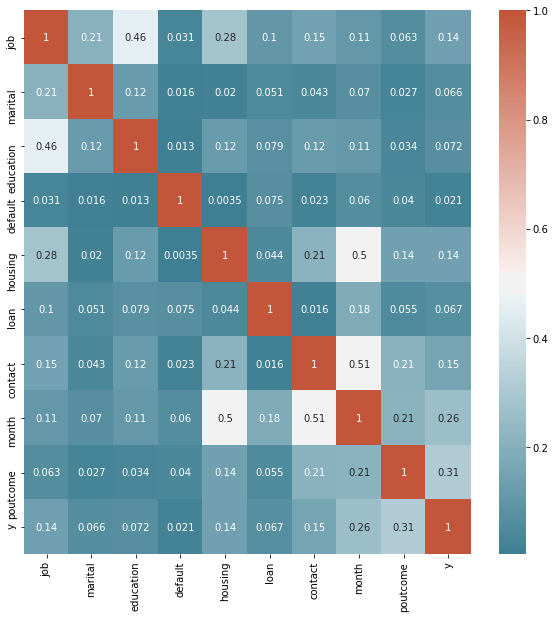

In [52]:
plt.figure(figsize=(10,10))
sns.heatmap(corr_cat_df, annot=True, cmap=sns.diverging_palette(220,20, n=300))
plt.xticks(rotation=90);

**Note:** some correlation is noticed between housing loan and job, which makes sense. The correlations between month and housing and contact might indicate some kind of seasonality, still ought to be checked.

## Feature Engineering for exploration

In [53]:
df.head(2)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no


In [54]:
df['day'].dtypes

dtype('int64')

In [55]:
df['month'].dtypes

dtype('O')

**note:** considering all of the data is related to the marketing campaign throughout the year of 2019 

In [56]:
df['date'] = pd.to_datetime((df['day'].astype(str) + "/" +  df['month']+ '/2019'), format='%d/%b/%Y')

In [57]:
# check if the customer has any loan
df['any_loan'] = (df['housing']=='yes').astype(int) * (df['loan']=='yes').astype(int)

In [58]:
# check if the customer has any kind of pendencies on the market
df['any_pendencies'] = (df['housing']=='yes').astype(int) * (df['loan']=='yes').astype(int) * (df['default']=='yes').astype(int)

In [59]:
df['education'].value_counts()

secondary    20951
tertiary     11917
primary       6153
unknown       1669
Name: education, dtype: int64

In [60]:
df.loc[df['education']=='unknown', 'education_ord'] = 0
df.loc[df['education']=='primary', 'education_ord'] = 1
df.loc[df['education']=='secondary', 'education_ord'] = 2
df.loc[df['education']=='tertiary', 'education_ord'] = 3

In [61]:
df.head(2)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,date,any_loan,any_pendencies,education_ord
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no,2019-05-05,0,0,3.0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no,2019-05-05,0,0,2.0


In [62]:
df['week'] = df['date'].dt.week

In [63]:
df['month_number'] = df['date'].dt.month

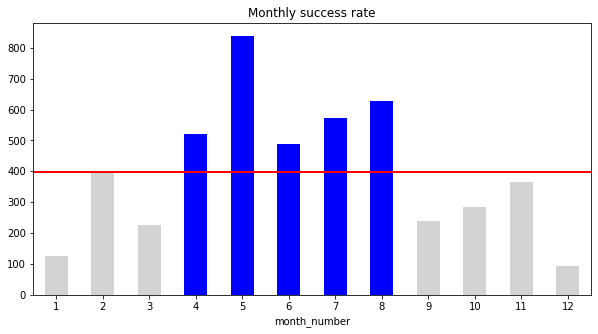

In [64]:
plt.figure(figsize=(10,5))
bars = df[df['y']=='yes'].groupby(by='month_number').size().plot.bar(color=(['lightgray',
                                                                             'lightgray',
                                                                             'lightgray',
                                                                             'blue',
                                                                             'blue',
                                                                             'blue',
                                                                             'blue',
                                                                             'blue',
                                                                             'lightgray',
                                                                             ]))
plt.axhline(linewidth=2, color='r', y = df[df['y']=='yes'].groupby(by='month_number').size().mean())
plt.xticks(rotation=0)
plt.title('Monthly success rate');

**What explains the higher success rate on this period?**

In red we can see the yearly average for counts of positive responses for the marketing campaign; In gray are months that show up below average and in blue months that are above the average.

Why were these 5 months the most successful in terms of last contact? Were there any different campaigns that happened at that period? Are the customer more prone to respond positevly when contacted in the middle of the year? Depending on where the company and the customers are located, there might as well be a relationship with the weather condition (US = summer, Brazil = winter)

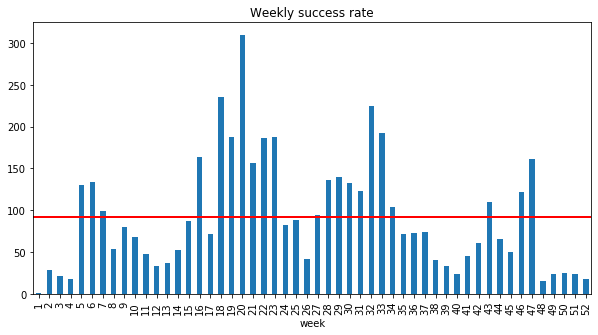

In [65]:
plt.figure(figsize=(10,5))
df[df['y']=='yes'].groupby(by='week').size().plot.bar()
plt.axhline(linewidth=2, color='r', y = df[df['y']=='yes'].groupby(by='week').size().mean())
plt.title('Weekly success rate');

There are also some weeks that operate below the average on the "good months". This is something the business would help us clarify to understand exactly what has happened in the marketing campaign stories.

## Machine Learning model experimentation

For this type of problem, tree algorithms tend to work out pretty well, and have a good explainability of how the decisions were made by the trees and which variables are important. Since we are not aiming for the best metric possible, but rather a decent working algorithm, we will first be working with the **RandomForest Classifier** from ```scikit-learn```

In [66]:
df.head(2)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,date,any_loan,any_pendencies,education_ord,week,month_number
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no,2019-05-05,0,0,3.0,18,5
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no,2019-05-05,0,0,2.0,18,5


In [67]:
df_dummy = pd.get_dummies(df.drop(['education', 'date'], axis=1), drop_first=True)

In [68]:
df_dummy.head()

,age,balance,day,duration,campaign,pdays,previous,any_loan,any_pendencies,education_ord,week,month_number,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,default_yes,housing_yes,loan_yes,contact_telephone,contact_unknown,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown,y_yes
0,58,2143,5,261,1,-1,0,0,0,3.0,18,5,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
1,44,29,5,151,1,-1,0,0,0,2.0,18,5,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
2,33,2,5,76,1,-1,0,1,0,2.0,18,5,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
3,47,1506,5,92,1,-1,0,0,0,0.0,18,5,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
4,33,1,5,198,1,-1,0,0,0,0.0,18,5,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0


In [69]:
X = df_dummy.drop('y_yes', axis=1)
y= df_dummy['y_yes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [70]:
clf = RandomForestClassifier(n_estimators=100, max_depth=5, n_jobs=-1)

In [71]:
cross_val_score(clf, X_train, y_train, cv=5)

array([0.89204845, 0.89468141, 0.89362823, 0.89202949, 0.8929073 ])

**Considerations** 

The cross validation score seems to be very consisten for 5 folds. So let us dive a little bit deeper to check the classification report and the other quality metrics for the classification problem

In [72]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [73]:
target_names = ['yes', 'no']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

         yes       0.89      1.00      0.94     10716
          no       0.82      0.12      0.21      1491

    accuracy                           0.89     12207
   macro avg       0.85      0.56      0.57     12207
weighted avg       0.88      0.89      0.85     12207



As is shown, there is still room for improvement, specially for the recall of class 1 (no). In the first exploration we saw that this was an imbalanced problem, so some re-sampling should make the model work better.

### Over sampling - ADASYN

In [74]:
ada = ADASYN(random_state=42)
X_res, y_res = ada.fit_resample(X, y)

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
target_names = ['yes', 'no']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

         yes       0.92      0.86      0.89     10856
          no       0.87      0.93      0.90     11061

    accuracy                           0.90     21917
   macro avg       0.90      0.90      0.90     21917
weighted avg       0.90      0.90      0.90     21917



**Considerations** 

Having the recall being enhanced with the over-sampling method, we have now reached viable testing metrics. It is important to notice there are still room for improvements!

### Explaining feature importances for the Random Forest algorithm

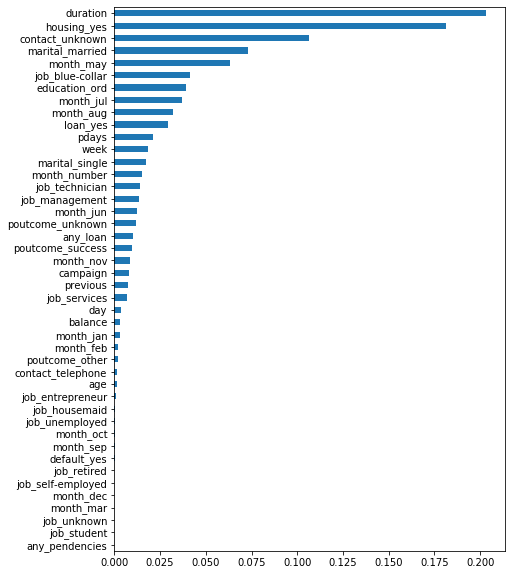

In [76]:
feat_importances = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=True)
plt.figure(figsize=(7,10))
feat_importances.plot.barh()

**Conclusion from Random Forest Classifier**

This feature importances plot matches pretty well with the discussions raised throughout the Exploratory Data Analysis part and the most important features to make the predictions make sense!

### Experimenting with a Gradient-boosting algorithm

In [77]:
xgb = XGBClassifier()

cross_val_score(xgb, X_train, y_train, cv=5)

array([0.94632382, 0.94123973, 0.94955025, 0.94994134, 0.94358072])

In [78]:
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
target_names = ['yes', 'no']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

         yes       0.94      0.95      0.94     10856
          no       0.95      0.94      0.95     11061

    accuracy                           0.94     21917
   macro avg       0.94      0.94      0.94     21917
weighted avg       0.94      0.94      0.94     21917



This boosting algorithm performed even better as the Random Forest Classifier. Let us try to see if the same variables were as important, using a different approach, based on the games theory. 

### Explaining using Shapley values

In [79]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_res)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


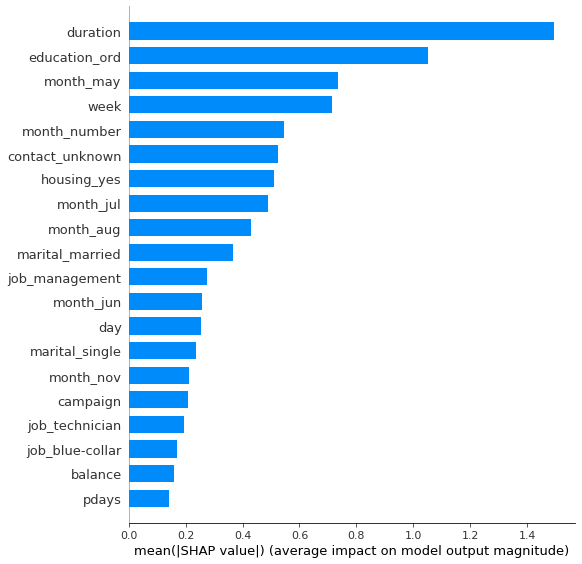

In [80]:
shap.summary_plot(shap_values, X_res, plot_type="bar")

**Considerations**

The ordinal-encoded education also contributed for the XGBoost model, as well as the other explained features.

# Insights and considerations - EDA + Machine Learning

### EDA

Analyzing the last campaign and how the customers behaved for this one, there are a few insights that are pointed out from the Data Science team by analyzing the data:

* It seems that there is a higher positive response when the marketing campaign is made in the middlle of the year, **specially in May** 📅

* The more is known about the communication channel, the best! Mobile is the most used and should be kept as main point of contact 📱

* The time investment for the marketing campaign should focus more on non-married people, if possible 

* We should **avoid** trying to sell the product to customer with any market pendencies, but specially a housing loan 🏘️

* People with higher degree of education tend to respond more positively 📚

* Our offer needs to be remembered, so contact is mandatory. But a high amount of contacts will make us lose them. 

* The contact should have **quality**, making a customer-centric, empathic approach and making the contact for a longer period will raise the chance of getting a positive answer! 🚀

---

### Machine Learning

The decisions made by the algorithms point out that the insights on the EDA were correct. Decent metrics were achieved with almost no effort, making it a viable option for turning this predictor into a product in the future.

---

### Conclusions

These assumptions were made in order for us to have a data-driven guideline for planning our next marketing campaigns. But all insights and discussions raised will push this discussion forward for us to better understand how to correctly interpret these informations and constantly improve our studies.